# Basic Information

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct 18 02:55:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   27C    P0    42W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

recognition/s45533675/Demo3.ipynb

Requirement: Implement a brain MRI super-resolution network by training on the ADNI brain dataset. Create down-sampled data (approximately by a factor of 4) using Tensorflow implementations. The network should be trained to up-scale from 4x down-sampled input and produce a “reasonably clear image".

# Set Up Environment


In [2]:
import tensorflow as tf
print("TF Version:", tf.__version__)

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

TF Version: 2.9.2


# Load data

Download dataset.
I use the built-in keras.utils.get_file utility to retrieve the dataset.

In [3]:
dataset_url = "https://cloudstor.aarnet.edu.au/plus/s/L6bbssKhUoUdTSI/download"
data_dir = keras.utils.get_file(origin=dataset_url, fname="ADNI", extract=True)


185710993/185710993 [==============================] - 15s 0us/step


*   Because this task is not a classification problem, I just use the images in the AD train as my whole dataset.
*   The number of images is 10400 and it completely fits the training requirement.
*   The origin path is ADNI_AD_NC_2D\AD_NC\train\AD and I rename the ADNI_AD_NC_2D to ADNI and newpath is ADNI\AD_NC\train\AD.

In [4]:
root_dir = os.path.join("/root/.keras/datasets/AD_NC/train/AD")

Then I create training and validation datasets via image_dataset_from_directory.

The image size is 256 x 240. The number of images is 10400 so I choose 10% as validation set which is 1040.

In [27]:
crop_size = 240
upscale_factor = 4
input_size = crop_size // upscale_factor
batch_size = 32

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 10400 files belonging to 1 classes.
Using 8320 files for training.
Found 10400 files belonging to 1 classes.
Using 2080 files for validation.


# Pre process images

Normalization

I rescale the images to take values in the range [0, 1].

In [28]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

Demonstrate the first batch.

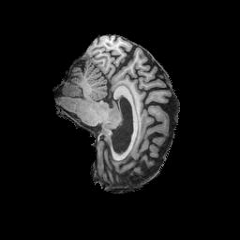

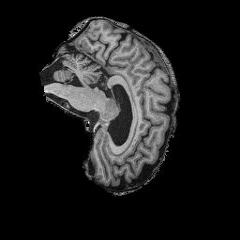

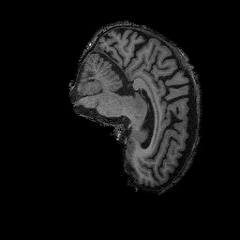

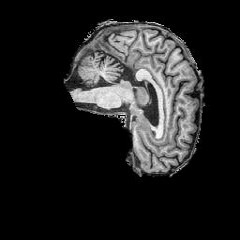

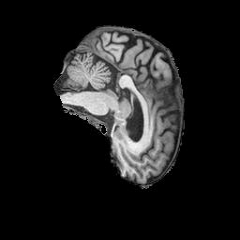

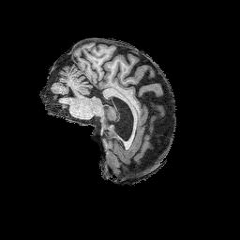

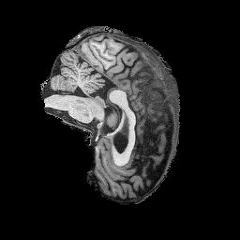

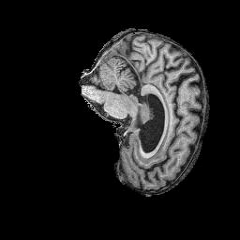

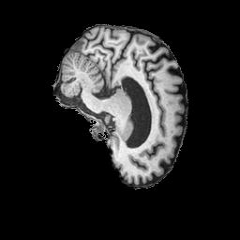

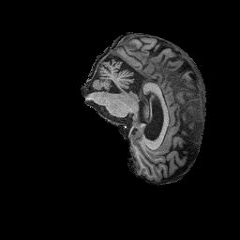

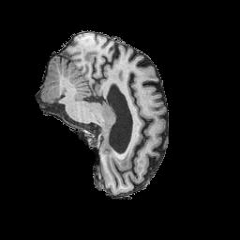

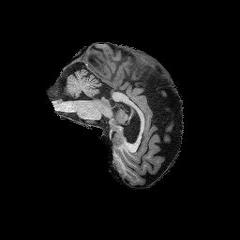

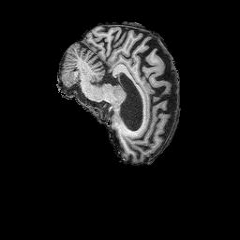

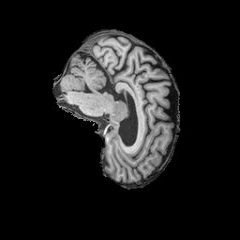

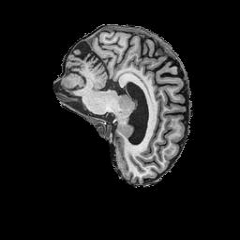

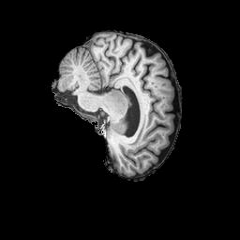

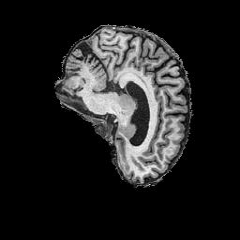

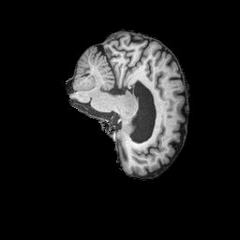

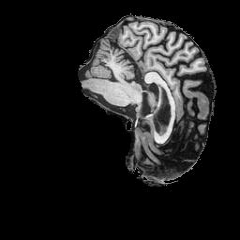

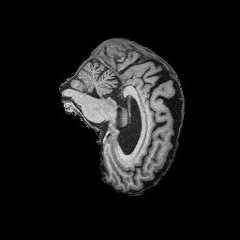

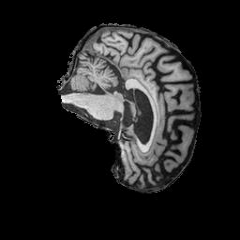

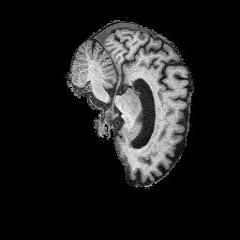

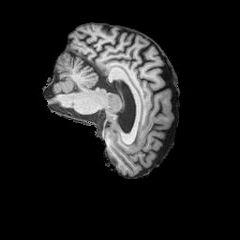

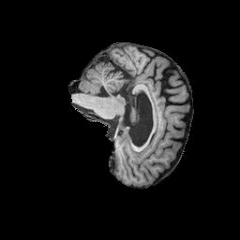

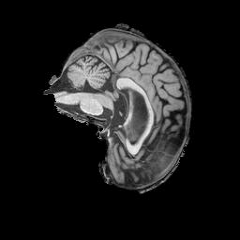

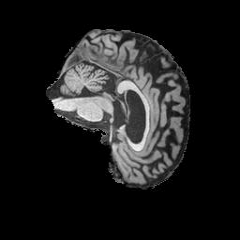

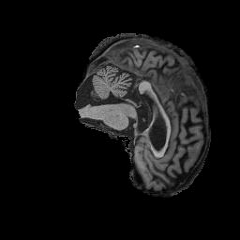

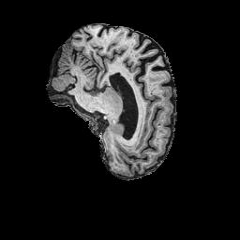

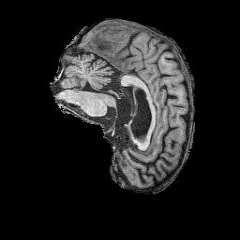

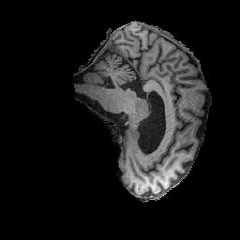

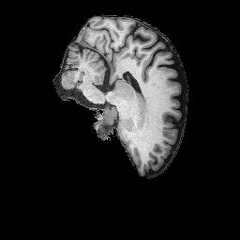

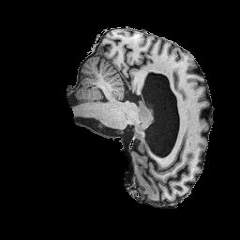

In [29]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

I use images in AD_NC/test/AD as test images for visual evaluation at the end.


In [30]:
test_path = os.path.join("/root/.keras/datasets/AD_NC/test/AD")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpeg")
    ]
)

*   I downsample the original images to low-resolution images, and the original images are high-resolution images.
*   Set low-resolution images to 0 axis, high-resolution images to 1 axis.



In [31]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

Show the first processed batch.

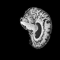

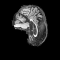

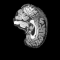

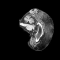

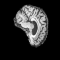

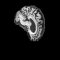

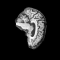

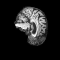

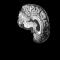

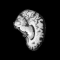

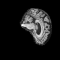

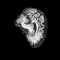

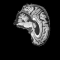

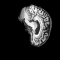

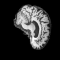

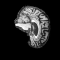

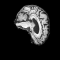

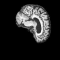

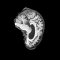

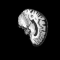

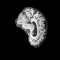

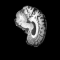

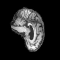

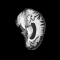

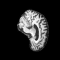

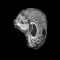

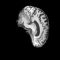

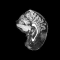

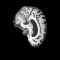

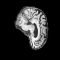

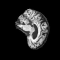

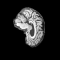

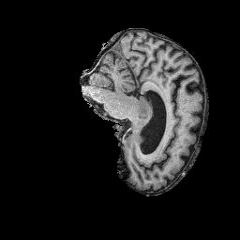

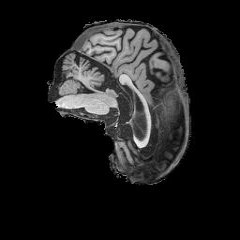

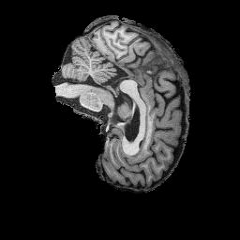

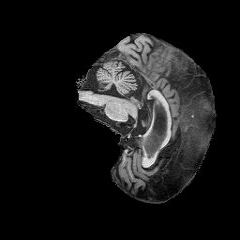

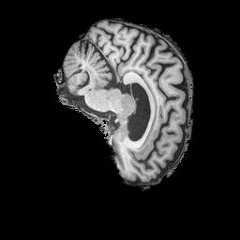

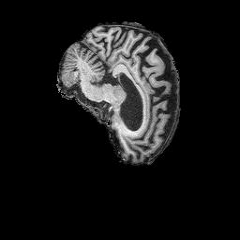

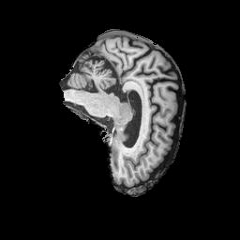

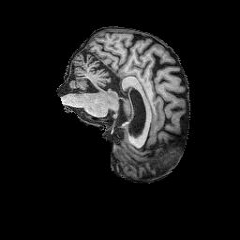

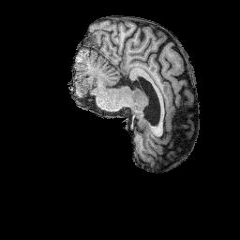

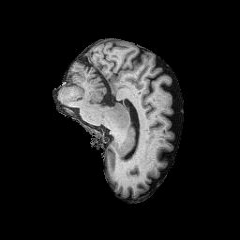

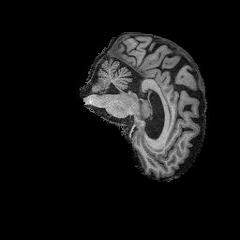

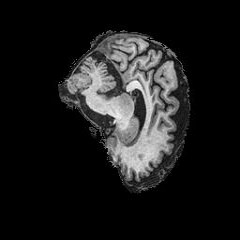

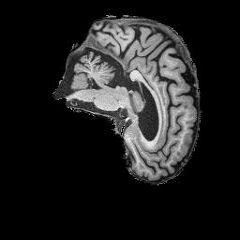

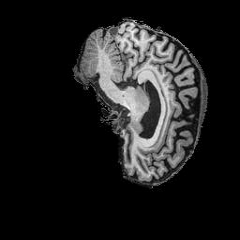

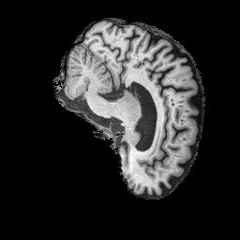

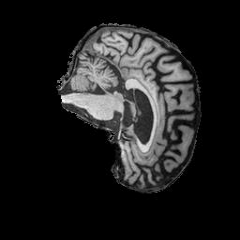

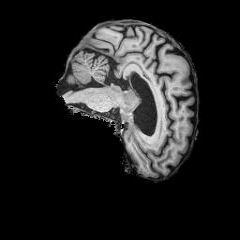

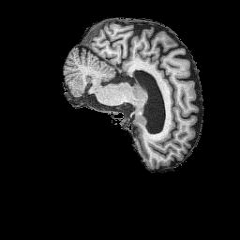

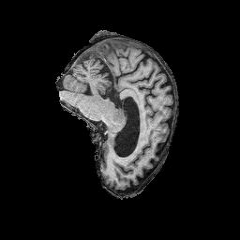

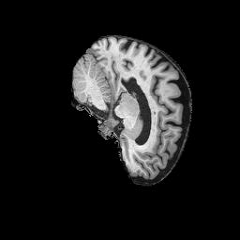

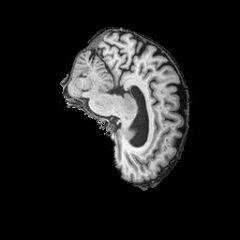

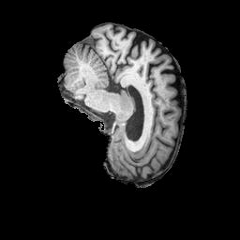

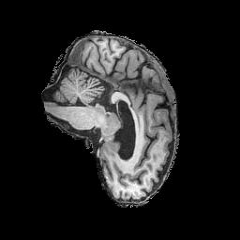

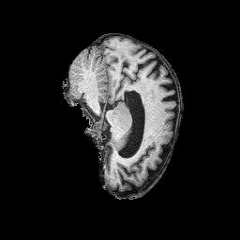

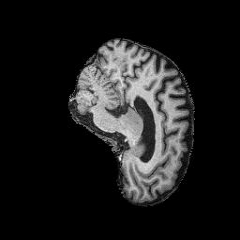

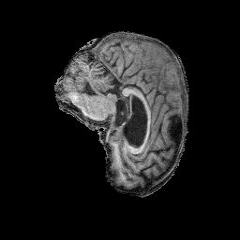

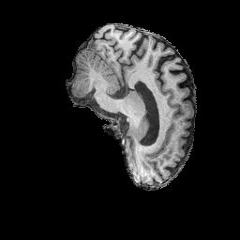

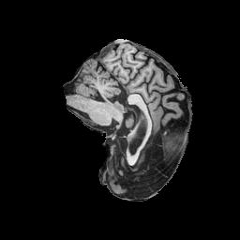

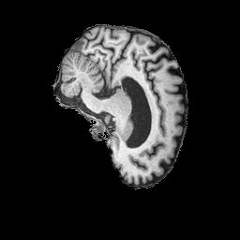

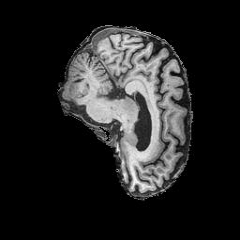

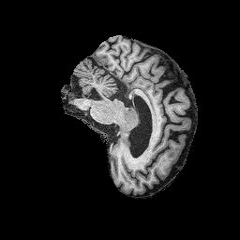

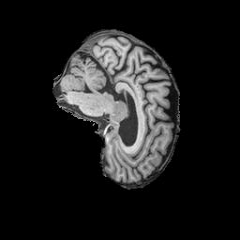

In [32]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

# Build the model

In [33]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 50, 100, 125, 175
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".jpeg")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [35]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [36]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

Epoch 1/100
Mean PSNR for epoch: 20.38
1/1 [==============================] - 0s 384ms/step


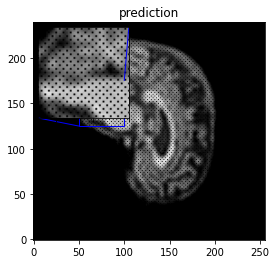

260/260 - 15s - loss: 0.0126 - val_loss: 0.0092 - 15s/epoch - 57ms/step
Epoch 2/100
Mean PSNR for epoch: 20.44
260/260 - 3s - loss: 0.0092 - val_loss: 0.0091 - 3s/epoch - 13ms/step
Epoch 3/100
Mean PSNR for epoch: 20.45
260/260 - 3s - loss: 0.0091 - val_loss: 0.0090 - 3s/epoch - 13ms/step
Epoch 4/100
Mean PSNR for epoch: 20.47
260/260 - 3s - loss: 0.0091 - val_loss: 0.0090 - 3s/epoch - 13ms/step
Epoch 5/100
Mean PSNR for epoch: 20.49
260/260 - 3s - loss: 0.0090 - val_loss: 0.0089 - 3s/epoch - 13ms/step
Epoch 6/100
Mean PSNR for epoch: 20.50
260/260 - 3s - loss: 0.0090 - val_loss: 0.0089 - 3s/epoch - 13ms/step
Epoch 7/100
Mean PSNR for epoch: 20.51
260/260 - 3s - loss: 0.0090 - val_loss: 0.0089 - 3s/epoch - 13ms/step
Epoch 8/100
Mean PSNR for epoch: 20.52
260/260 - 4s - loss: 0.0090 - val_loss: 0.0089 - 4s/epoch - 14ms/step
Epoch 9/100
Mean PSNR for epoch: 20.52
260/260 - 4s - loss: 0.0090 - val_loss: 0.0089 - 4s/epoch - 14ms/step
Epoch 10/100
Mean PSNR for epoch: 20.53
260/260 - 4s - l

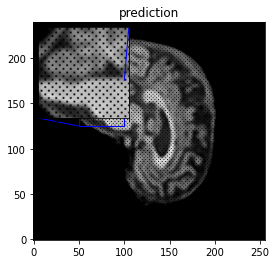

260/260 - 5s - loss: 0.0089 - val_loss: 0.0088 - 5s/epoch - 18ms/step
Epoch 22/100
Mean PSNR for epoch: 20.55
260/260 - 3s - loss: 0.0089 - val_loss: 0.0088 - 3s/epoch - 13ms/step
Epoch 23/100
Mean PSNR for epoch: 20.54
260/260 - 3s - loss: 0.0089 - val_loss: 0.0088 - 3s/epoch - 13ms/step
Epoch 24/100
Mean PSNR for epoch: 20.54
260/260 - 3s - loss: 0.0089 - val_loss: 0.0088 - 3s/epoch - 13ms/step
Epoch 25/100
Mean PSNR for epoch: 20.56
260/260 - 3s - loss: 0.0089 - val_loss: 0.0088 - 3s/epoch - 13ms/step
Epoch 26/100
Mean PSNR for epoch: 20.55
260/260 - 3s - loss: 0.0089 - val_loss: 0.0088 - 3s/epoch - 13ms/step
Epoch 27/100
Mean PSNR for epoch: 20.56
260/260 - 3s - loss: 0.0089 - val_loss: 0.0088 - 3s/epoch - 13ms/step
Epoch 28/100
Mean PSNR for epoch: 20.57
260/260 - 3s - loss: 0.0089 - val_loss: 0.0088 - 3s/epoch - 13ms/step
Epoch 29/100
Mean PSNR for epoch: 20.57
260/260 - 3s - loss: 0.0089 - val_loss: 0.0088 - 3s/epoch - 13ms/step
Epoch 30/100
Mean PSNR for epoch: 20.56
260/260 - 

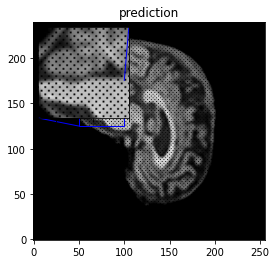

260/260 - 4s - loss: 0.0088 - val_loss: 0.0087 - 4s/epoch - 16ms/step
Epoch 42/100
Mean PSNR for epoch: 20.56
260/260 - 3s - loss: 0.0088 - val_loss: 0.0088 - 3s/epoch - 13ms/step
Epoch 43/100
Mean PSNR for epoch: 20.57
260/260 - 3s - loss: 0.0088 - val_loss: 0.0087 - 3s/epoch - 13ms/step
Epoch 44/100
Mean PSNR for epoch: 22.89
260/260 - 3s - loss: 0.0074 - val_loss: 0.0052 - 3s/epoch - 13ms/step
Epoch 45/100
Mean PSNR for epoch: 22.89
260/260 - 3s - loss: 0.0052 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 46/100
Mean PSNR for epoch: 22.89
260/260 - 3s - loss: 0.0052 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 47/100
Mean PSNR for epoch: 22.87
260/260 - 3s - loss: 0.0052 - val_loss: 0.0052 - 3s/epoch - 13ms/step
Epoch 48/100
Mean PSNR for epoch: 22.91
260/260 - 3s - loss: 0.0052 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 49/100
Mean PSNR for epoch: 22.90
260/260 - 3s - loss: 0.0052 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 50/100
Mean PSNR for epoch: 22.92
260/260 - 

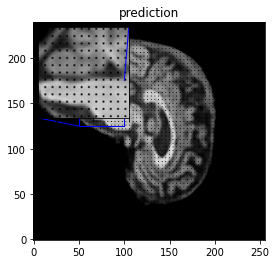

260/260 - 4s - loss: 0.0051 - val_loss: 0.0051 - 4s/epoch - 16ms/step
Epoch 62/100
Mean PSNR for epoch: 22.92
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 63/100
Mean PSNR for epoch: 22.93
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 64/100
Mean PSNR for epoch: 22.92
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 65/100
Mean PSNR for epoch: 22.93
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 66/100
Mean PSNR for epoch: 22.94
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 67/100
Mean PSNR for epoch: 22.93
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 68/100
Mean PSNR for epoch: 22.94
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 69/100
Mean PSNR for epoch: 22.95
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 70/100
Mean PSNR for epoch: 22.94
260/260 - 

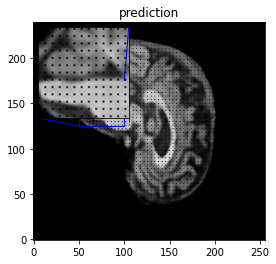

260/260 - 4s - loss: 0.0051 - val_loss: 0.0051 - 4s/epoch - 15ms/step
Epoch 82/100
Mean PSNR for epoch: 22.96
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 83/100
Mean PSNR for epoch: 22.94
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 84/100
Mean PSNR for epoch: 22.94
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 85/100
Mean PSNR for epoch: 22.96
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 86/100
Mean PSNR for epoch: 22.96
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 87/100
Mean PSNR for epoch: 22.94
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 88/100
Mean PSNR for epoch: 22.94
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 89/100
Mean PSNR for epoch: 22.97
260/260 - 3s - loss: 0.0051 - val_loss: 0.0051 - 3s/epoch - 13ms/step
Epoch 90/100
Mean PSNR for epoch: 22.96
260/260 - 

In [37]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Prediction